# Examples for Task Parameterized Gaussian Mixture Models


Load dataset. You can find more details about the dataset at: https://theairlab.org/trajair/


In [22]:
import sys

sys.path.append("/".join(sys.path[0].split("/")[:-1]))

In [23]:
from tpgmm.utils.file_system import load_txt
from tpgmm.utils.casting import ssv_to_ndarray

from tpgmm.utils.plot.plot import plot_trajectories

import numpy as np

from glob import glob
from numpy import ndarray

In [24]:
class DiffFilter:
    def __init__(self, threshold: float = np.exp(-2)) -> None:
        # if max diff is bigger than np.exp(-2) ~ 0.1353352832366127 -> return false
        self._threshold: float = threshold

    def __call__(self, data: ndarray) -> bool:
        if np.max(np.abs(np.diff(data, axis=0))) >= self._threshold:
            return False
        return True


class GroundFilter:
    def __init__(self, threshold: float = 0.1) -> None:
        self._threshold: float = threshold

    def __call__(self, data: ndarray) -> bool:
        if min(data[:, 2]) <= self._threshold:
            return True
        return False

(<Figure size 1000x800 with 1 Axes>, <Axes3D: title={'center': 'flight'}>)

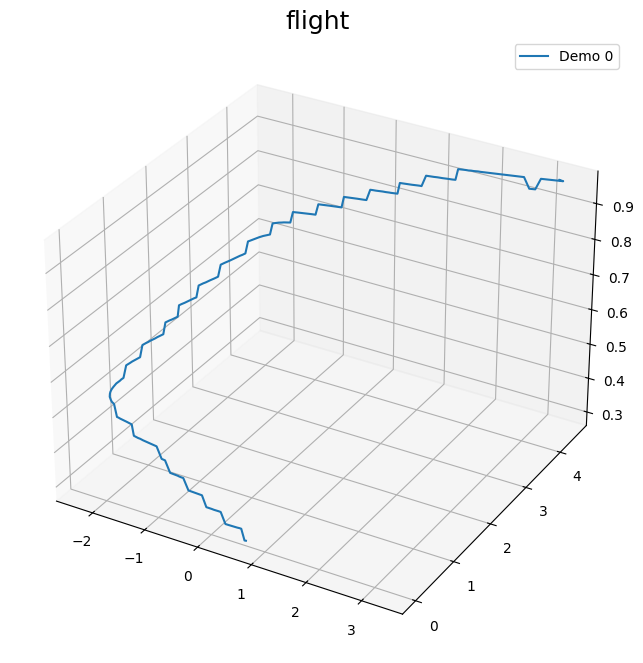

In [25]:
trajectories = []
for data_path in glob("data/7days1/processed_data/*/*.txt"):
    data = map(lambda x: ssv_to_ndarray(x), load_txt(data_path))
    data = np.stack(list(data))[:, 2:5]
    trajectories.append(data)

diff_filter = DiffFilter()
ground_filter = GroundFilter(0.3)

trajectories = list(filter(ground_filter, filter(diff_filter, trajectories)))
plot_trajectories(
    title="flight",
    trajectories=trajectories[50][None],
    legend=True,
)

Select one trajectory and generate similar ones based on the selected one   

(<Figure size 1000x800 with 1 Axes>, <Axes3D: title={'center': 'flight'}>)

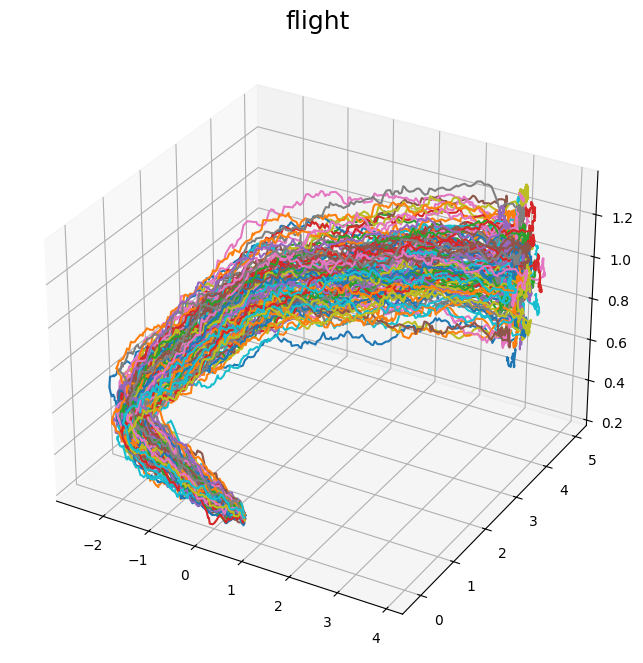

In [26]:
trajectory = trajectories[50]  # start trajectory

trajectory_vector = np.diff(trajectory, axis=0)

synthetic_trajectories = []
num_trajectories = 120
for _ in range(num_trajectories):
    synthetic_trajectory = np.zeros_like(trajectory) 
    noise = np.random.normal(0, 0.01, size=synthetic_trajectory.shape)
    synthetic_trajectory[0] = trajectory[0] + noise[0]
    for traj_idx in range(1, len(trajectory)):
        traj_point = synthetic_trajectory[traj_idx - 1] + trajectory_vector[traj_idx - 1] + noise[traj_idx]
        synthetic_trajectory[traj_idx] = traj_point
    synthetic_trajectories.append(np.stack(synthetic_trajectory))
# noise = np.random.normal(0, 0.5,)

plot_trajectories(
    title="flight",
    trajectories=synthetic_trajectories,
    legend=False,
)

In [27]:
trajectories = synthetic_trajectories

Preprocess data with following requirements.

- Trajectories have to have all the same length
- Transform into start position
- Transform into end position
- If not provided add time vector


In [28]:
from enum import Enum
from typing import Any, List, Literal, Union
from scipy import interpolate

from numpy import ndarray


class SamplingMode(Enum):
    MIN = 0
    MEAN = 1
    MAX = 2


class PreProcessor:
    def __init__(
        self,
        capture_frequency: float,
        num_samples: Union[
            Literal[SamplingMode.MAX],
            Literal[SamplingMode.MEAN],
            Literal[SamplingMode.MIN],
            int,
        ] = SamplingMode.MIN,
        frame_idx: List[int] = [0, -1],
    ) -> None:
        self.capture_frequency = capture_frequency
        self.num_samples = num_samples
        self.frame_idx = frame_idx  # determine from which frames inside the trajectory are determined to be reference frames for the GMR

    def __call__(self, data: Union[List[ndarray], ndarray]) -> ndarray:
        """_summary_

        Args:
            data (Union[List[ndarray], ndarray]): shape: (num_trajectories, num_points, num_features)
                num_trajectories: number of recorded and loaded trajectories
                num cluster points refers to the number of points inside a point framework like hand-landmarks (num_cluster_points = 21) from google mediapipe

        Returns:
            ndarray: shape: (num_trajectories, num_frames, num_points, num_features) num features contains x, y, z and time
        """
        trajectories = self.unify_length(data, self.num_samples)
        
        # translate trajectories into respected start and end frames with a constant rotation matrix
        local_trajectories = self.translate_trajectories(trajectories)

        # add capture time information
        local_trajectories = self.add_time(local_trajectories)

        # local_trajectories = np.concatenate(local_trajectories, axis=1)
        return local_trajectories
    
    def unify_length(self, 
        trajectories: List[ndarray],
        sampling_mode: Union[
            Literal[SamplingMode.MIN],
            Literal[SamplingMode.MAX],
            Literal[SamplingMode.MEAN],
            int,
        ] = SamplingMode.MIN,
    ) -> ndarray:
        """Normalize all the demos list and put all the values together in an unique
        ndarray: UNDERSAMPLING

        Args:
            demos (List[ndarray]): list of demonstration data. Each list element is a demonstration (ndarray).
            A demonstration element is a ndarray with shape (len_demo, num_features). Assumption num_features is greater equal 3 -> first
            indices: x, y, z information
            sampling_mode (SamplingMode, optional): _description_. Defaults to SamplingMode.UNDERSAMPLING.

        Raises:
            NotImplementedError: if sampling_mode is not equal SamplingMode.UNDERSAMPLING

        Returns:
            ndarray: all trajectories interpolated to the same length. Shape: (num_trajectories, num_points, 3). Last dimension is x, y, z
        """
        num_samples = None
        trajectoriy_lengths = map(lambda x: len(x), trajectories)
        if sampling_mode == SamplingMode.MIN:
            num_samples = min(trajectoriy_lengths)
        elif sampling_mode == SamplingMode.MEAN:
            num_samples = int(np.mean(trajectoriy_lengths))
        elif sampling_mode == SamplingMode.MAX:
            num_samples = max(trajectoriy_lengths)
        elif isinstance(sampling_mode, int):
            num_samples = sampling_mode

        unified_trajectories = []
        for trajectory in trajectories:
            # create splines and sample points from the spline to get a uniform length of each trajectory
            tck, u = interpolate.splprep(trajectory[:, :3].T, k=3, s=0)
            u = np.linspace(0, 1, num=num_samples, endpoint=True)
            unified_trajectories.append(interpolate.splev(u, tck))

        unified_trajectories = np.stack(unified_trajectories).swapaxes(-1, -2)

        return unified_trajectories

    def translate_trajectories(self, trajectories: ndarray, ) -> ndarray:
        # get pick and place translation from trajectories as first and last position
        start_end_translation = trajectories[:, [0, -1], :]
        means = start_end_translation.mean(0)
        print("mean start: ", means[0])
        print("mean end: ", means[1])
        result = np.empty((2, *trajectories.shape))
        for frame_idx in range(2):
            points = trajectories.swapaxes(0, 1) - start_end_translation[:, frame_idx] 
            result[frame_idx] = points.swapaxes(0, 1)
        
        return result

    def add_time(
        self, trajectories: Union[List[ndarray], ndarray]) -> Union[List[ndarray], ndarray]:
        """adds to every point on the trajectory its recorded timestamp with the assumption all trajectories started at t = 0

        Args:
            trajectories (Union[List[ndarray], ndarray]): trajectories. Shape: (...., num_points, 3)
            freq (float): recording frequency

        Returns:
            Union[List[ndarray]: trajectories with time information. Shape (..., num_points, 4). Last dimension is (x, y, z, time)
        """

        if isinstance(trajectories, ndarray):
            # create time vector
            traj_shape = trajectories.shape
            # ASSUMPTION: values at index: -2 = num_points

            time = np.arange(
                0,
                traj_shape[-2] * (1 / self.capture_frequency),
                1 / self.capture_frequency,
            )
            print(f"time feature between {time[0]} and {time[-1]}. {len(time)} time instances")

            # bump up dimensionality to match trajectories
            time = time.reshape((1,) * 2 + (-1, 1))
            time = np.broadcast_to(time, (*traj_shape[:-1], 1))

            return np.concatenate([trajectories, time], axis=-1)

        else:
            raise ValueError("wrong input type. Supported is: ndarray")
        

num_samples = 200
capture_freq = 100
pre_processor = PreProcessor(capture_freq, num_samples)

pre_processed_data = pre_processor(trajectories)
# plot_trajectories(trajectories=pre_processed_data[0, [15]])



mean start:  [0.64787246 0.00070664 0.2744464 ]
mean end:  [3.25701513 4.46887246 0.98744594]
time feature between 0.0 and 1.99. 200 time instances


In [29]:
from tpgmm.tpgmm.tpgmm import TPGMM


tpgmm = TPGMM(5)
num_trajectories = pre_processed_data.shape[1]
concatenated_trajectories = np.reshape(
    pre_processed_data, (2, num_trajectories * num_samples, 4)
)

tpgmm.fit(concatenated_trajectories)

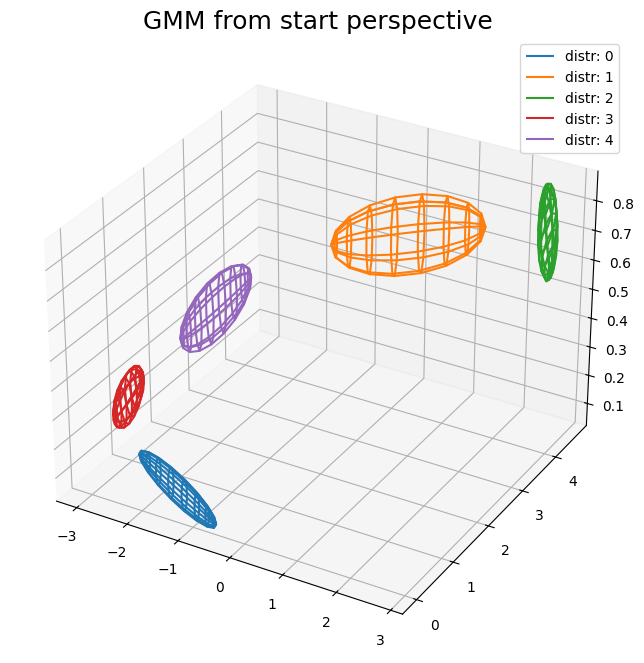

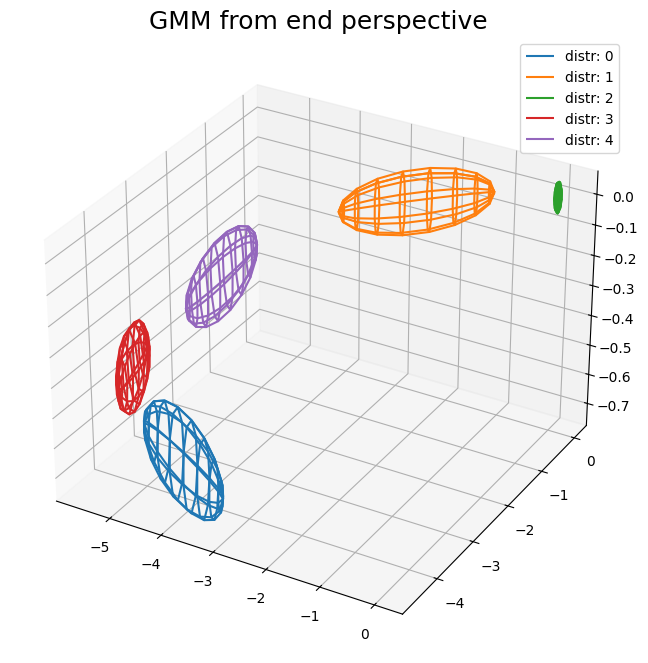

In [30]:
from tpgmm.gmr.gmr import GaussianMixtureRegression
from tpgmm.utils.plot.plot import plot_ellipsoids

frame_idx = 0
plot_ellipsoids(
    title="GMM from start perspective", means=tpgmm.means_[frame_idx, :, :3], covs=tpgmm.covariances_[frame_idx, :, :3, :3], legend=True
)
frame_idx = 1
plot_ellipsoids(
    title="GMM from end perspective", means=tpgmm.means_[frame_idx, :, :3], covs=tpgmm.covariances_[frame_idx, :, :3, :3], legend=True
)


gmr = GaussianMixtureRegression.from_tpgmm(tpgmm, [3])

translation = np.array(
    [[0.67434406, -0.10956558, 0.31207092], [1.52133899, 0.03424608, 0.40956669]]
)
translation = np.array([[ 0.64892812, -0.00127319,  0.27268653], [3.25658728, 4.49575041, 0.95660171]])
rotation_matrix = np.eye(3)[None].repeat(2, axis=0)
gmr.fit(translation=translation, rotation_matrix=rotation_matrix)

Distance to desired positions:
 start: 0.04572092305869371 
 end: 0.04953894985519691


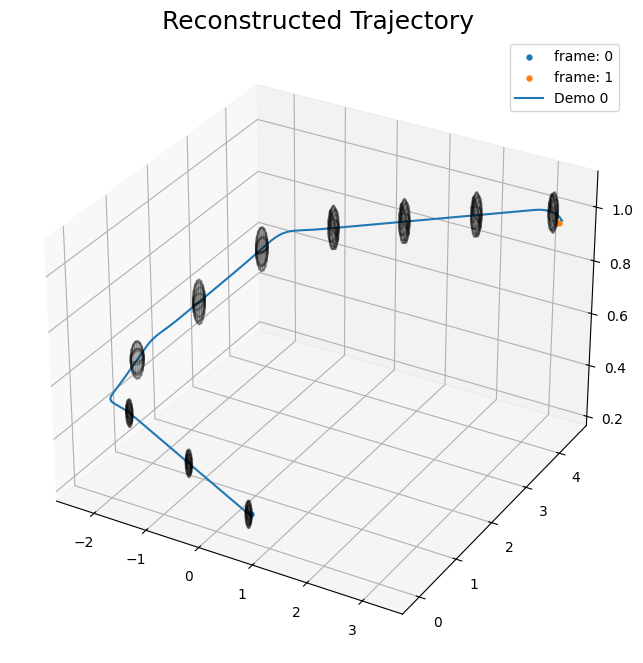

In [31]:
from tpgmm.utils.plot.plot import scatter


input_data = np.linspace(0, 2, 200)[:, None]
mu, cov = gmr.predict(input_data)

fig, ax = scatter(title="Reconstructed Trajectory", data=translation[: ,None])
fig, ax = plot_trajectories(trajectories=mu[None], fig=fig, ax=ax, legend=True)
plot_ellipsoids(
    means=mu[::20], covs=cov[::20], fig=fig, ax=ax, color="k", alpha=0.3
)
print(f"Distance to desired positions:\n start: {np.linalg.norm(translation[0] - mu[0])} \n end: {np.linalg.norm(translation[1] - mu[-1])}")